In [1]:
import requests
parameter = {
    'id': 'ethereum',
    'vs_currency': 'usd',
    'from': '1650982222',
    'to': '1658758222'
}
response = requests.get('https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range?vs_currency=usd&from=1650982222&to=1658758222')

print(len(response.json()['prices']))

2155


In [2]:
prices = [tpl[1] for tpl in response.json()['prices']]

print(prices)

[2910.511361838363, 2880.0649753319203, 2877.946491223888, 2863.980135041006, 2856.718245787325, 2842.9472615862173, 2827.9482020755217, 2842.1822721346593, 2826.7896674963094, 2811.0027700110945, 2816.083226516498, 2838.0735423378414, 2841.335333669573, 2837.218780755947, 2843.4059488943017, 2851.626553525252, 2868.174615352483, 2884.5790164454943, 2884.5309232902123, 2903.1545875633215, 2901.4478783880236, 2879.1538843520834, 2873.591675134141, 2909.837454408673, 2851.6810639075243, 2868.5203205414496, 2879.938499573389, 2876.3206076790707, 2851.267044746288, 2853.4911473981188, 2866.0059413909853, 2888.2136572679997, 2878.3081287619243, 2888.200033065152, 2904.7805038886954, 2879.212760602357, 2897.771151775598, 2885.3983999779375, 2886.906498098474, 2881.6180128215324, 2887.1135598900296, 2902.176493721568, 2933.5074188551102, 2939.6925711563736, 2931.7798854363505, 2926.7948282106377, 2914.6369546027718, 2881.084404894626, 2876.661753108538, 2887.4632932604086, 2929.5266485864618,

In [12]:
import mesa
from decimal import *
import pandas as pd
from IPython.display import display

from contracts import router_factory
from agents.buyer import BuyerAgent
from agents.oracle import Oracle
from agents.lp_provider import ProviderAgent
from states.params import Params
from contracts.types import DummyProtocolAgent, Tokens

"""Model Data Collector Methods"""

def eth_prices(model):
    return Oracle.get_price_of("ETH")

def sa_balance(model):
    return model.router._sa_pool.balance


def fee_balance(model):
    return model.router._fee_pool.balance


def va_balance(model):
    return model.router._va_pool.balance * Oracle.get_price_of("ETH")

def principal(model):
    return model.router._sa_pool.principal


def total(model):
    return (
        model.router._sa_pool.balance
        + model.router._fee_pool.balance
        + model.router._va_pool.balance * Oracle.get_price_of("ETH")
    )


def num_triggered(model):
    return model.router.num_triggered


def num_rebalanced(model):
    return model.router.num_rebalanced


class LifelyPayModel(mesa.Model):
    def __init__(self, n):
        super().__init__()
        self._step = 0
        self.router = router_factory.Router("ETH", "USDC")

        # Initiate w/ $1M Protocol-injected Liquidity
        self.router.process_lp_provider_request(
            DummyProtocolAgent(), Tokens(Decimal(3000000), "USDC")
        )

        self.schedule = mesa.time.RandomActivation(self)
        for i in range(n):
            ba = BuyerAgent(i, "DIMWIT-" + str(i), self.router, self)
            # buyer gets infinite ETH to spend
            # amount paid and amount redeemed is tracked separately
            ba.initiate_with("ETH")
            self.schedule.add(ba)

        # for i in range(n, 2 * n):
        #     pa = ProviderAgent(i, "DIPSHIT-" + str(i), self.router, self)
        #     # provider gets infinite USDC to stake
        #     # amount staked and amount redeemed is tracked separately
        #     pa.initiate_with("USDC")
        #     self.schedule.add(pa)

                        # "Principal": principal,
                #      "staker_staked_usd": "staked_usd",
                # "staker_redeemed_usd": "redeemed_usd",
                # "staker_APY": "apy",

        self.running = True
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "ETH Prices": eth_prices,
                "USDC Pool Balance USD": sa_balance,
                "ETH Pool Balance USD": va_balance,
                "Fee Pool Balance USDC": fee_balance,
                "Total Asset Value USD": total,
                "# Emergency Triggers": num_triggered,
                "# Pool Rebalancing": num_rebalanced,
            },
            agent_reporters={
                "buyer_spent_eth_usd": "spent_eth_usd",
                "buyer_redeemed_eth_usd": "redeemed_eth_usd",
                "buyer_remaining_vouchers": "remaining_vouchers",
            },
        )

    def step(self):
        Oracle.set_price(Decimal(str(prices[self._step])))
        self._step += 1
        self.schedule.step()
        self.datacollector.collect(self)


if __name__ == "__main__":
    getcontext().prec = 18
    results = mesa.batch_run(
        LifelyPayModel,
        parameters={"n": 50},
        iterations=1,
        max_steps=500,
        number_processes=1,
        data_collection_period=1,
        display_progress=False,
    )
    Params.hard_reset()
    Oracle.reset()
    rdf = pd.DataFrame(results)

2022-07-26 12:56:03,504 [WARNING] Attempting to Liquidate 0E-34 ETH
2022-07-26 12:56:03,507 [WARNING] Attempting to Liquidate 0E-34 ETH
2022-07-26 12:56:03,508 [WARNING] Attempting to Liquidate 0E-33 ETH
2022-07-26 12:56:03,510 [WARNING] Attempting to Liquidate 0E-33 ETH
2022-07-26 12:56:03,511 [WARNING] Attempting to Liquidate 0E-34 ETH
2022-07-26 12:56:03,513 [WARNING] Attempting to Liquidate 0E-34 ETH
2022-07-26 12:56:03,516 [WARNING] Attempting to Liquidate 0E-34 ETH
2022-07-26 12:56:03,518 [WARNING] Attempting to Liquidate 0E-34 ETH
2022-07-26 12:56:03,520 [WARNING] Attempting to Liquidate 0E-34 ETH
2022-07-26 12:56:03,521 [WARNING] Attempting to Liquidate 0E-34 ETH
2022-07-26 12:56:03,522 [WARNING] Attempting to Liquidate 0E-34 ETH
2022-07-26 12:56:03,523 [WARNING] Attempting to Liquidate 0E-33 ETH
2022-07-26 12:56:03,524 [WARNING] Attempting to Liquidate 0E-34 ETH
2022-07-26 12:56:03,526 [WARNING] Attempting to Liquidate 0E-34 ETH
2022-07-26 12:56:03,529 [WARNING] Attempting to 

/var/folders/pt/l_q9hfpx33j6tqj3v05dqykh0000gn/T/ipykernel_42260/3154109960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['Total Asset Value USD'] = filtered['Total Asset Value USD'].astype(float)
/var/folders/pt/l_q9hfpx33j6tqj3v05dqykh0000gn/T/ipykernel_42260/3154109960.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['ETH Prices'] = filtered['ETH Prices'].astype(float)
/var/folders/pt/l_q9hfpx33j6tqj3v05dqykh0000gn/T/ipykernel_42260/3154109960.py:23: SettingWithCopyWarning: 
A

,RunId,iteration,Step,n,ETH Prices,USDC Pool Balance USD,ETH Pool Balance USD,Fee Pool Balance USDC,Total Asset Value USD,# Emergency Triggers,# Pool Rebalancing,AgentID,buyer_spent_eth_usd,buyer_redeemed_eth_usd,buyer_remaining_vouchers
1,0,0,1,50,2880.0649753319203,614188.498420725426,2366337.00895768563,47716.2300315854914,3028241.73740999655,0,0,0.0,17758.7217881741927,0,6.10158133069690934
51,0,0,2,50,2877.946491223888,198596.525071487444,2780188.38013625634,56028.0694985702509,3034812.97470631404,0,0,0.0,17758.7217881741927,0,6.10158133069690934
101,0,0,3,50,2863.980135041006,0E-13,2965292.95833142082,60451.5440748612807,3025744.50240628210,0,1,0.0,17758.7217881741927,0,6.10158133069690934
151,0,0,4,50,2856.718245787325,0E-13,2957774.18094722833,60451.5440748612807,3018225.72502208961,0,1,0.0,17758.7217881741927,0,6.10158133069690934
201,0,0,5,50,2842.9472615862173,0E-13,2943516.05045909446,61179.8332526970671,3004695.88371179153,0,3,0.0,17758.7217881741927,0,6.10158133069690934
251,0,0,6,50,2827.9482020755217,0E-13,2927986.40170054161,61179.8332526970671,2989166.23495323868,0,3,0.0,17758.7217881741927,0,6.10158133069690934
301,0,0,7,50,2842.1822721346593,0E-13,2942723.99963229280,61179.8332526970671,3003903.83288498987,0,3,0.0,17758.7217881741927,0,6.10158133069690934
351,0,0,8,50,2826.7896674963094,0E-13,2926786.88415232632,61179.8332526970671,2987966.71740502339,0,3,0.0,17758.7217881741927,0,6.10158133069690934
401,0,0,9,50,2811.0027700110945,0E-13,2910441.52778129216,61179.8332526970671,2971621.36103398923,0,3,0.0,17758.7217881741927,0,6.10158133069690934
451,0,0,10,50,2816.083226516498,0E-13,2915701.70459476240,61179.8332526970671,2976881.53784745947,0,3,0.0,17758.7217881741927,0,6.10158133069690934


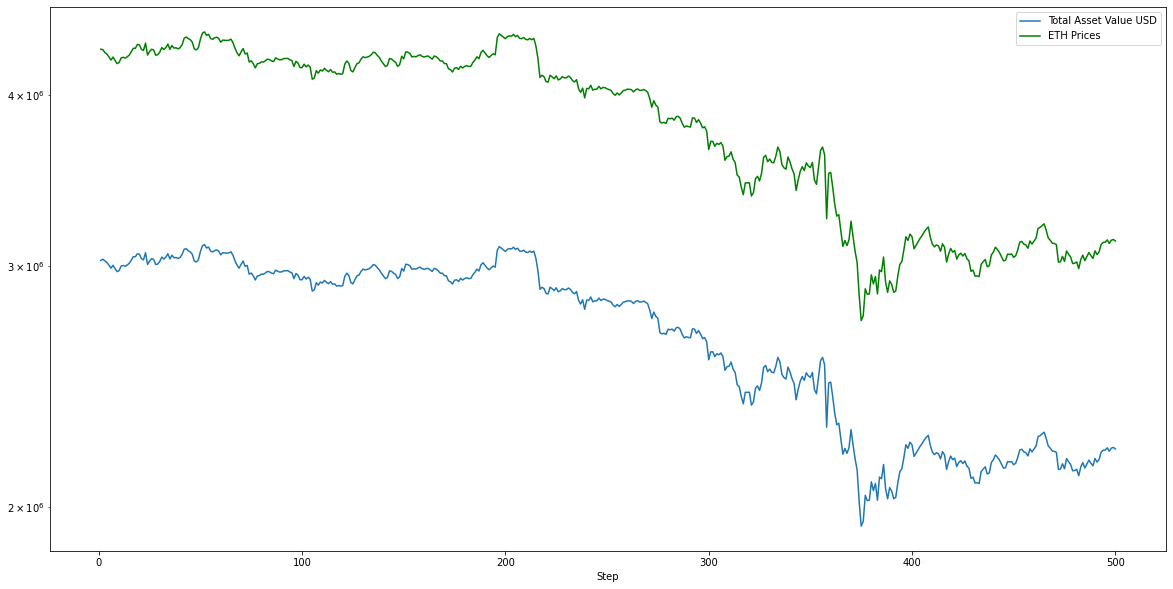

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
pd.set_option('display.max_rows', None)
one_iteration = rdf[(rdf.iteration == 0)]

filtered = one_iteration.loc[(one_iteration['AgentID'] == 0)]

filtered['Total Asset Value USD'] = filtered['Total Asset Value USD'].astype(float)


# filtered['Principal'] = filtered['Principal'].astype(float)
# filtered['buyer_redeemed_eth_usd'] = filtered['buyer_redeemed_eth_usd'].astype(float)
# filtered['buyer_remaining_vouchers'] = filtered['buyer_remaining_vouchers'].astype(float)
#
# filtered['buyer_spent_eth_usd'] = filtered['buyer_spent_eth_usd'].astype(float)
# filtered['buyer_redeemed_eth_usd'] = filtered['buyer_redeemed_eth_usd'].mul(1e3)
# filtered['buyer_remaining_vouchers'] = filtered['buyer_remaining_vouchers'].mul(1e3)


# filtered['Total Asset Value USD'] = filtered['Total Asset Value USD'].astype(float)
# filtered['Principal'] = filtered['Principal'].astype(float)
filtered['ETH Prices'] = filtered['ETH Prices'].astype(float)
filtered['ETH Prices'] = filtered['ETH Prices'].mul(1.5e3)


#

# staker_f = one_iteration.loc[(one_iteration['AgentID'] == 50)]
# staker_f['staker_APY'] = staker_f['staker_APY'].astype(float)
# print(filtered['Total Asset Value USD'])
# filtered['Total Asset Value USD'] = filtered['Total Asset Value USD'].val
# print(filtered.dtypes)

ax = plt.gca()
ax.set_yscale('log')

#     .as_type(float)
# list(filtered.columns)
# display(filtered)
filtered.plot(kind='line',x='Step',y='Total Asset Value USD', ax=ax)
# filtered.plot(kind='line',x='Step', color='red', y='Principal', ax=ax)
filtered.plot(kind='line',x='Step',color='green',y='ETH Prices', ax=ax)

# ax.get_figure().savefig('asset_value.png')

# ax_2 = plt.gca()
# staker_f.plot(kind='line', x='Step', y='staker_APY', ax=ax_2)
# balances = filtered["Total Asset Value USD"].values
# valid_df = one_iteration.loc[(one_iteration['staker_APY'].notnull()) & (one_iteration['Step'] == 500)] #(one_iteration['buyer_spent_eth'] != 0)]
valid_df = one_iteration.loc[(one_iteration['AgentID'] == 0)] #(one_iteration['buyer_spent_eth'] != 0)]

display(valid_df)